# Load the libraries and the models

In [10]:
import pandas as pd
import os
import spacy
import numpy as np
import random
from collections import Counter
import subprocess
import sys
import matplotlib.pyplot as plt
import seaborn as sns


# load the spacy model with the universal sentence encoder
# https://spacy.io/universe/project/spacy-universal-sentence-encoder
nlp = spacy.load('en_use_md')

# Load the datasets
reviews_df = pd.read_csv('imdb_reviews_cleaned.csv')
event_types_df = pd.read_csv('dataset_event_types.csv')

# Compare reviews with events

The code below compares the texts of the reviews with the parts of the each movie that corresponds to an event. For instance, for the text-event pair "X saves money every month-stative event", we compare the text with all the reviews for a given movie.

The resulting csv will have every pair of review-text event-text regardless of the similarity score. This is being done in order to enable future experiments with different thresholds and at the same time to evaluate the algorithm with matches that generate a low threshold.

In [ ]:
def analyze_similarity(reviews, event_descriptions):
    significant_pairs = []
    for review in reviews:
        review_sentences = [sent.text for sent in nlp(review).sents]  # break review into sentences to compare similar units
        for event_description in event_descriptions:
            event_sentences = [sent.text for sent in nlp(event_description).sents]  # break event description into sentences to compare similar units
            for review_sentence in review_sentences:
                review_doc = nlp(review_sentence)
                for event_sentence in event_sentences:
                    event_doc = nlp(event_sentence)
                    similarity = review_doc.similarity(event_doc)
                    significant_pairs.append((review_sentence, event_sentence, similarity))
    return significant_pairs

# iterate through each movie to compare its reviews with event descriptions
results = []

for movie in reviews_df['Movie Name'].unique():
    movie_reviews = reviews_df[reviews_df['Movie Name'] == movie]['Review'].tolist()
    movie_events = event_types_df[event_types_df['Movie'] == movie]['Event'].tolist()
    
    significant_pairs = analyze_similarity(movie_reviews, movie_events)  # Adjusted to collect pairs
    
    for review_sentence, event_sentence, similarity in significant_pairs:
        results.append({
            "Movie": movie,
            "Review": review_sentence,
            "Event": event_sentence,
            "Similarity_score": similarity
        })

results_df = pd.DataFrame(results)

# save the results to a CSV file
results_df.to_csv('review_event_similarity.csv', index=False)

In [ ]:
%%time

data = pd.read_csv("review_event_similarity.csv", encoding='utf-8', low_memory=True, memory_map=True)
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
# os.makedirs('data/', exist_ok=True)
data_0_5 = data[data['Similarity_score'] >= .5]
data_0_5.to_csv("mov_rev_sim_0_5.csv", encoding='utf-8')

In [11]:
# sort the DataFrame by similarity score
sorted_results_df = results_df.sort_values(by='Similarity_score')

# select 3 examples from each movie: lowest, medium, and highest similarity scores
final_results = []

for movie in sorted_results_df['Movie'].unique():
    movie_df = sorted_results_df[sorted_results_df['Movie'] == movie]
    if len(movie_df) >= 3:
        final_results.append(movie_df.iloc[0])  # lowest similarity score
        final_results.append(movie_df.iloc[len(movie_df) // 2])  # medium similarity score
        final_results.append(movie_df.iloc[-1])  # highest similarity score

final_results_df = pd.DataFrame(final_results)

from IPython.display import display
display(final_results_df[['Movie', 'Review', 'Event', 'Similarity_score']])

,Movie,Review,Event,Similarity_score
3103155,The Notebook,"I must say, for all us girls out there that ha...",but finds the gates locked.,-0.308178
2922180,The Notebook,If you're single and lonely... you will hate t...,but Allie's mother hides them.,0.071882
3300717,The Notebook,Noah writes to Allie everyday for a year.,Noah writes a letter to Allie every day for a ...,0.929330
1506751,The Matrix,It's tightly edited and the action rarely flags.,The group enters the Matrix to visit the Oracl...,-0.281639
241882,The Matrix,\n\nAt a technical level it is absolutely amaz...,"She flees, pursued by the police and a group o...",0.059176
420905,The Matrix,Trinity loves Neo?,Trinity confesses her love for Neo,0.870149
3877058,The Social Network,"The atmosphere is comfy, and the music is phen...","In separate depositions, the Winklevoss twins ...",-0.273897
3790970,The Social Network,"I try to avoid these in real life, preferring ...",and sees no value in disciplinary action on th...,0.068137
3765653,The Social Network,One includes the Winklevoss twins from Harvard...,"In separate depositions, the Winklevoss twins ...",0.813390
4471561,Notting Hill,\n\nAnd that's the key here.,Upon his arrival he is mistaken for a reporter...,-0.253132


# Visualizing Event Type Distribution per Movie
The code below visualizes the distribution of different event types across the four selected movies: "The Matrix," "The Notebook," "Notting Hill," and "The Social Network." The event types include "stative event," "process," "change of state," and "non-event." 

For each movie, the event types are counted and the results are presented in a 2x2 grid of subplots. Each subplot represents one of the movies and displays a bar plot of the event type counts. This visualization helps in understanding the frequency and distribution of various event types within each movie.

Event Type Counts per Movie:
Movie: Notting Hill
  stative_event: 3
  process: 45
  change_of_state: 2
  non_event: 1

Movie: The Social Network
  stative_event: 5
  process: 25
  change_of_state: 6
  non_event: 4

Movie: The Notebook
  stative_event: 4
  process: 50
  change_of_state: 15
  non_event: 5

Movie: The Matrix
  stative_event: 6
  process: 35
  change_of_state: 12
  non_event: 7



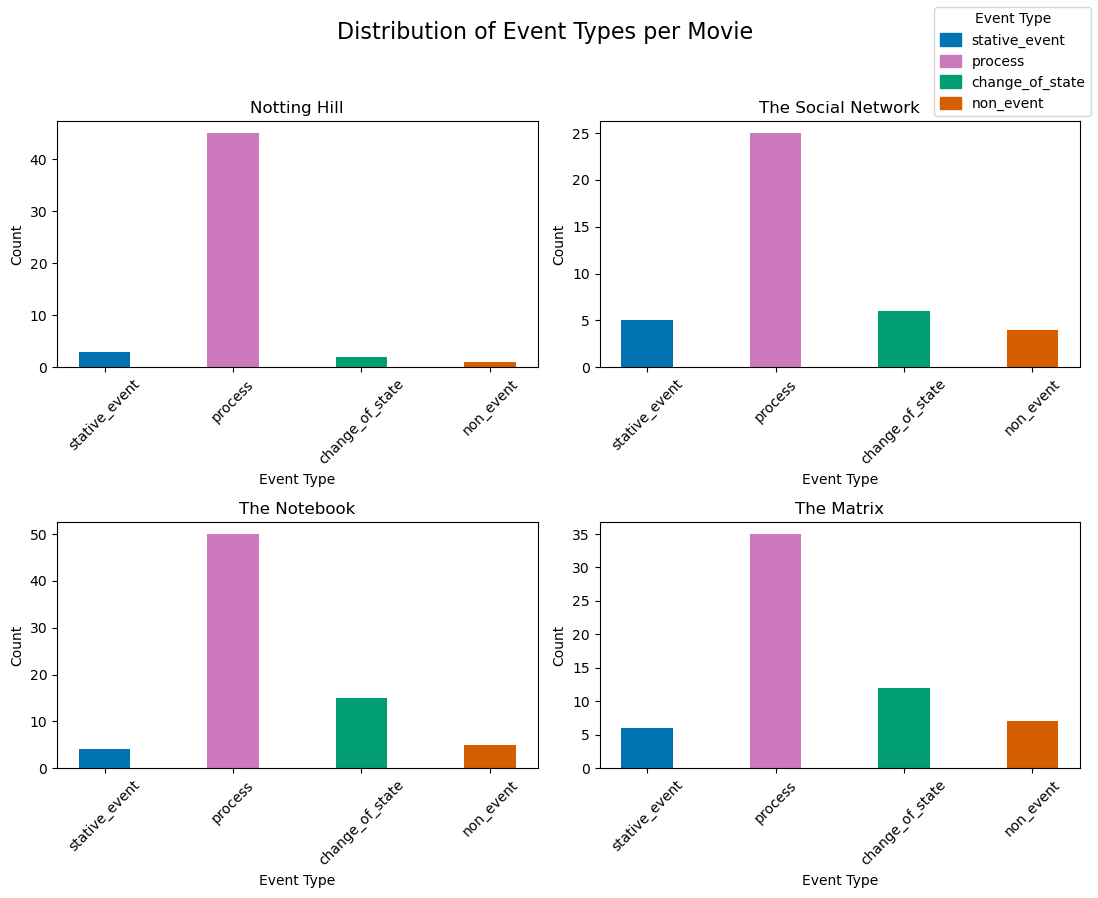

In [12]:
# Define a color map for each event type using a colorblind-friendly palette
color_map = {
    'stative_event': sns.color_palette("colorblind")[0],   # blue
    'process': sns.color_palette("colorblind")[4],         # purple
    'change_of_state': sns.color_palette("colorblind")[2], # green
    'non_event': sns.color_palette("colorblind")[3]        # orange
}

# Sample DataFrame setup for illustration
data = {
    'Movie': ['Notting Hill', 'The Social Network', 'The Notebook', 'The Matrix'],
    'stative_event': [3, 5, 4, 6],
    'process': [45, 25, 50, 35],
    'change_of_state': [2, 6, 15, 12],
    'non_event': [1, 4, 5, 7]
}

# Convert sample data to a DataFrame
event_counts_df = pd.DataFrame(data)

# Print the counts of each event type for each movie
print("Event Type Counts per Movie:")
for index, row in event_counts_df.iterrows():
    print(f"Movie: {row['Movie']}")
    for event_type in row.index[1:]:  # Skip the 'Movie' column
        print(f"  {event_type}: {row[event_type]}")
    print()  # Print a blank line for better readability

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(11, 9))
fig.suptitle('Distribution of Event Types per Movie', fontsize=16)

# Plotting each movie in a separate subplot
for ax, (index, row) in zip(axs.flatten(), event_counts_df.iterrows()):
    # Extracting event types and their counts for the current movie
    event_types = row.index[1:]  # Skip the 'Movie' column
    counts = row.values[1:]      # Skip the 'Movie' value
    colors = [color_map[event] for event in event_types]

    ax.bar(event_types, counts, color=colors, width=0.4)  # Adjusted width for thinner bars
    ax.set_title(row['Movie'])  # Use the movie name as the title
    ax.set_xlabel('Event Type')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Create a legend 
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[event]) for event in color_map]
labels = list(color_map.keys())
fig.legend(handles, labels, loc='upper right', title='Event Type', handleheight=1.0, handlelength=1.5)

# Remove grid lines for a cleaner look
for ax in axs.flatten():
    ax.grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
plt.savefig('event_type_distribution.png', bbox_inches='tight')

# Display the plot
plt.show()


In [13]:
# Load the CSV file containing the review-event similarity scores
results_df = pd.read_csv('review_event_similarity.csv')

# Total number of review-event pairs before filtering
total_pairs = len(results_df)
print(f"Total number of review-event pairs before filtering: {total_pairs}")

# Filter the DataFrame to keep only the rows with a similarity score greater or equal to 0.6
filtered_df = results_df[results_df['Similarity_score'] >= 0.6]

# Number of review-event pairs after filtering
filtered_pairs = len(filtered_df)
(f"Number of review-event pairs with a similarity score >= 0.60: {filtered_pairs}")

# Calculate the percentage of pairs that have a similarity score above 0.60
percentage_above_60 = (filtered_pairs / total_pairs) * 100
(f"Percentage of review sentences with a match above 0.60: {percentage_above_60:.2f}%")


Total number of review-event pairs before filtering: 4576692


'Percentage of review sentences with a match above 0.60: 0.04%'

# Filtering Review-Event Similarity Scores
The code below processes the previously generated CSV file containing review-event similarity scores. The goal is to filter out and keep only those pairs with a similarity score greater than or equal to 0.6. This threshold is chosen to focus on significant matches that demonstrate a strong semantic connection between the review sentences and the event descriptions.

In [14]:
# Load the CSV file containing the review-event similarity scores
results_df = pd.read_csv('review_event_similarity.csv')

# Filter the DataFrame to keep only the rows with a similarity score greater or equal to 0.6
filtered_df = results_df[results_df['Similarity_score'] >= 0.6]

# Calculate the percentage of review sentences with a similarity score above 0.6
total_review_sentences = len(results_df)  # Total number of review sentences
total_matching_sentences = len(filtered_df)  # Number of matching sentences with similarity score >= 0.6

percentage_matching = (total_matching_sentences / total_review_sentences) * 100
print(f"Percentage of review sentences with a match above 0.60: {percentage_matching:.2f}%")

# Save the filtered results to a new CSV file
filtered_df.to_csv('filtered_review_event_similarity.csv', index=False)

# Display the filtered results
filtered_df


Percentage of review sentences with a match above 0.60: 0.04%


,Movie,Review,Event,Similarity_score
12332,The Matrix,The scene where Neo and Trinity go to the virt...,Neo is taken by Trinity to meet Morpheus,0.663610
12876,The Matrix,The scene where Neo and Trinity go to the virt...,kills him before pulling Neo and Trinity from ...,0.644642
12927,The Matrix,The scene where Neo and Trinity go to the virt...,Neo resolves to return to the Matrix to rescue...,0.621764
13029,The Matrix,The scene where Neo and Trinity go to the virt...,Morpheus and Trinity safely exit the Matrix,0.653931
14803,The Matrix,Neo finds himself targeted by the police when ...,"Computer programmer Thomas Anderson, known by ...",0.619521
...,...,...,...,...
4470541,Notting Hill,A normal book seller William fell in love with...,"One day, famous Hollywood actress Anna Scott e...",0.639086
4489812,Notting Hill,William Thacker (Hugh Grant) is a bookshop own...,"One day, famous Hollywood actress Anna Scott e...",0.614769
4518957,Notting Hill,She was so impressive while asking his lover t...,"She proclaims that she loves him, \nand pleads...",0.607116
4538305,Notting Hill,One day he has a very special customer: Anna S...,"One day, famous Hollywood actress Anna Scott e...",0.646319


In [15]:
# Load the CSV file containing the review-event similarity scores
results_df = pd.read_csv('review_event_similarity.csv')

# Total number of review-event pairs before filtering
total_pairs = len(results_df)
print(f"Total number of review-event pairs before filtering: {total_pairs}")

# Filter the DataFrame to keep only the rows with a similarity score greater or equal to 0.6
filtered_df = results_df[results_df['Similarity_score'] >= 0.6]

# Number of review-event pairs after filtering
filtered_pairs = len(filtered_df)
print(f"Number of review-event pairs with a similarity score >= 0.60: {filtered_pairs}")

# Calculate the percentage of pairs that have a similarity score above 0.60
percentage_above_60 = (filtered_pairs / total_pairs) * 100
print(f"Percentage of review sentences with a match above 0.60: {percentage_above_60:.2f}%")


Total number of review-event pairs before filtering: 4576692
Number of review-event pairs with a similarity score >= 0.60: 1983
Percentage of review sentences with a match above 0.60: 0.04%


# Counting Matching Sentences per Movie and Event
The code below analyzes the filtered review-event similarity data to count the number of significant matches. These counts provide insights into how frequently specific events are mentioned in the reviews for each movie, and how common these events are in the context of audience discussions.

By performing these counts, we can check the engagement and relevance of different events in the movies based on user reviews.

In [19]:
# Load the filtered CSV file
filtered_df = pd.read_csv('filtered_review_event_similarity.csv')

# Count the number of matching sentences per movie
matching_sentences_per_movie = filtered_df.groupby('Movie').size().reset_index(name='Count')
print("Number of matching sentences per movie:")
matching_sentences_per_movie

# Count the number of matching sentences per event
matching_sentences_per_event = filtered_df.groupby(['Movie', 'Event']).size().reset_index(name='Count')
print("\nNumber of matching sentences per event:")
matching_sentences_per_event

# Calculate the total number of matching sentences per movie
total_matching_sentences_per_movie = matching_sentences_per_movie['Count'].sum()
print(f"Total number of matching sentences across all movies: {total_matching_sentences_per_movie}")

# Calculate the total number of matching sentences per event across all movies
total_matching_sentences_per_event = matching_sentences_per_event['Count'].sum()
print(f"Total number of matching sentences across all events: {total_matching_sentences_per_event}")

# Count the number of unique reviews that have at least one matching sentence with a summary event
unique_reviews_with_matches = filtered_df['Review'].nunique()
print(f"Total number of unique reviews paired with summary events: {unique_reviews_with_matches}")

# Calculate the number of unique reviews that were paired with events for each movie
reviews_paired_with_events = filtered_df.groupby('Movie')['Review'].nunique().reset_index(name='Unique Reviews Paired with Events')

# Calculate the number of matching sentences for each movie
matching_sentences_per_movie = filtered_df.groupby('Movie').size().reset_index(name='Matching Sentences')

# Merge the results into a single DataFrame for easy viewing
result_df = pd.merge(reviews_paired_with_events, matching_sentences_per_movie, on='Movie')

# Display the result
print(result_df)

Number of matching sentences per movie:

Number of matching sentences per event:
Total number of matching sentences across all movies: 1983
Total number of matching sentences across all events: 1983
Total number of unique reviews paired with summary events: 1065
                Movie  Unique Reviews Paired with Events  Matching Sentences
0        Notting Hill                                 32                  34
1          The Matrix                                597                1224
2        The Notebook                                176                 327
3  The Social Network                                260                 398


# Analyzing Event Type Frequency in Matching Reviews
The code below further analyzes the filtered review-event similarity data by merging it with the event type information. This allows us to count and display the frequency of each event type mentioned in the significant review-event pairs, showing which types of events are most discussed by the audience.

Frequency of Event Types with Matching Reviews:


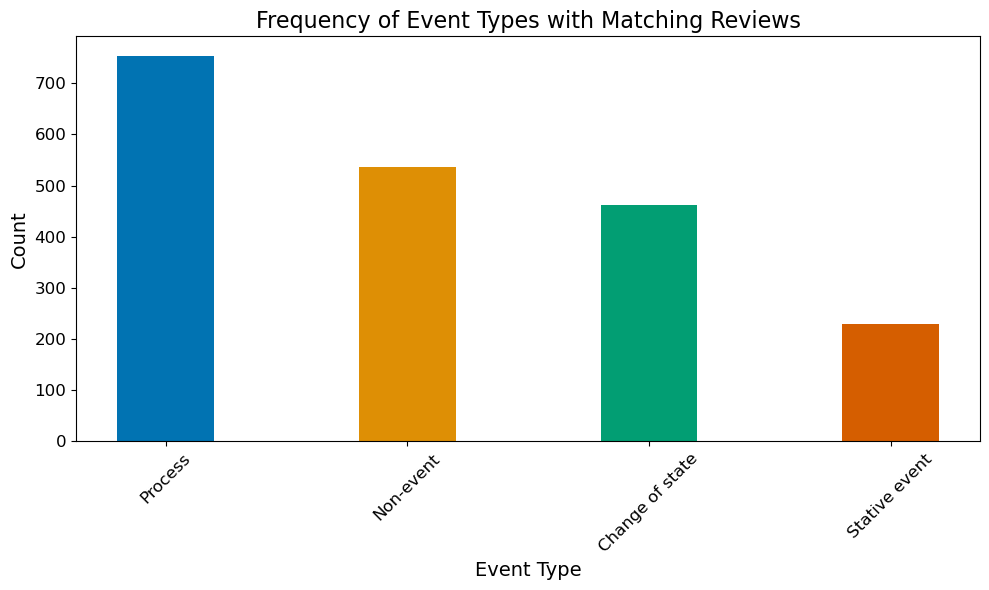

In [6]:
# Merge the filtered_df with event_types_df to include the Event_Type column
merged_df = pd.merge(filtered_df, event_types_df[['Movie', 'Event', 'Event Type']], on=['Movie', 'Event'], how='left')

# Count the occurrences of each event type
event_type_frequency = merged_df['Event Type'].value_counts().reset_index(name='Count')
event_type_frequency.columns = ['Event_Type', 'Count']

# Calculate the total count for each event type
total_count = event_type_frequency['Count'].sum()
event_type_frequency.loc['Total'] = ['Total', total_count]

# Display the frequency of event types
print("Frequency of Event Types with Matching Reviews:")
event_type_frequency

# Data for plotting
event_types = ['Process', 'Non-event', 'Change of state', 'Stative event']
counts = [754, 537, 462, 230]

# Set the style and color palette
colors = sns.color_palette("colorblind")  # Use colorblind-friendly palette

# Data for plotting
event_types = ['Process', 'Non-event', 'Change of state', 'Stative event']
counts = [754, 537, 462, 230]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(event_types, counts, color=colors, width=0.4)

# Add title and labels
plt.title('Frequency of Event Types with Matching Reviews', fontsize=16)
plt.xlabel('Event Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig('event_type_frequency.png', bbox_inches='tight')

# Display the plot
plt.show()